# Emotion Analysis assignment 2
In this assignment we are going to perform 

## Imports and parameters

In [1]:
import os
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/tmp/ipykernel_1499364/1574673180.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# glove_path = "/mnt/d/Downloads/glove.6B.100d.txt"
# dataset_path = "/mnt/e/Mastering Computational Linguistics/Semester 4/Emotion analysis/Assignments/Assignment2/data/unified-dataset.tsv"

glove_path = "./glove.6B.100d.txt"
dataset_path = "./data/unified-dataset.tsv"

## Exploring the dataset

In [3]:
data = pd.read_csv(dataset_path, sep="\t", header=None, error_bad_lines=False, names=["index", "ds", "tweet", "emotion"])
data.head()

/tmp/ipykernel_1499364/1095128175.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(dataset_path, sep="\t", header=None, error_bad_lines=False, names=["index", "ds", "tweet", "emotion"])
Skipping line 4829: expected 4 fields, saw 5
Skipping line 18068: expected 4 fields, saw 6
Skipping line 19349: expected 4 fields, saw 5
Skipping line 129300: expected 4 fields, saw 9
Skipping line 129336: expected 4 fields, saw 7
Skipping line 129411: expected 4 fields, saw 6
Skipping line 129734: expected 4 fields, saw 5
Skipping line 129772: expected 4 fields, saw 6
Skipping line 129876: expected 4 fields, saw 5
Skipping line 129921: expected 4 fields, saw 8
Skipping line 130021: expected 4 fields, saw 6
Skipping line 130075: expected 4 fields, saw 6
Skipping line 130184: expected 4 fields, saw 6
Skipping line 130278: expected 4 fields, saw 6
Skipping line 130381: expected 4 fields, sa

,index,ds,tweet,emotion
0,0,tec,Thinks that @melbahughes had a great 50th birt...,surprise
1,1,tec,"Como una expresión tan simple, una sola oració...",sadness
2,2,tec,the moment when you get another follower and y...,joy
3,3,tec,Be the greatest dancer of your life! practice ...,joy
4,4,tec,eww.. my moms starting to make her annual rum ...,disgust


In [4]:
data["ds"].value_counts()

dailydialogues             102979
crowdflower                 39738
tec                         21048
tales-emotion               13693
isear                        7666
emoint                       7102
ssec                         4868
electoraltweets              4056
emotiondata-aman             4025
fb-valence-arousal-anon      2871
grounded_emotions            2585
emotion-cause                2397
affectivetext                1249
Name: ds, dtype: int64

In [5]:
data[data.ds=="crowdflower"]["emotion"].value_counts()

noemo       9370
joy         9220
fear        8428
sadness     5123
love        3820
surprise    2177
anger       1421
disgust      179
Name: emotion, dtype: int64

In [6]:
data[data.ds=="dailydialogues"]["emotion"].value_counts()

noemo       85572
joy         12885
surprise     1823
sadness      1150
anger        1022
disgust       353
fear          174
Name: emotion, dtype: int64

In [7]:
dataset_name = "electoraltweets"
split = data[data.ds == dataset_name].reset_index(drop=True)
split.head()

,index,ds,tweet,emotion
0,137133,electoraltweets,"I'm a #Republican, but if I have to hear my mo...",disgust
1,137134,electoraltweets,Will Obama fire the person responsible for thi...,anger
2,137135,electoraltweets,haha @DickMorrisTweet Romney is going to have ...,anger
3,137136,electoraltweets,S/0 to my newest @freeboosieRS &amp vote for O...,anticipation
4,137137,electoraltweets,Nicki Minaj Fucked Up With That Mitt Romney Li...,anger


In [9]:
import re
from nltk.stem import WordNetLemmatizer

def find_mention(text:str, replacement:str="Person"):
    """
    Find the mentions and replace it by person by default.
    """
    rex = re.compile(r"\B@(\w+)")
    mention = bool(re.search(rex, text))
    return mention

def clean_mention(text:str, replacement:str="Person"):
    """
    Clean the mentions and replace it by person by default.
    """
    rex = re.compile(r"\B@(\w+)")
    cleaned = re.sub(rex, replacement, string=text)
    return cleaned

def find_hashtag(text:str, replacement:str=""):
    """
    Finds the hashtags completely. 
    This is especially useful to test the influence of hashtags on outcome.
    """
    rex = re.compile(r"\B#(\w+)")
    mention = bool(re.search(rex, text))
    return mention

def clean_hashtags(text:str, replacement:str=""):
    """
    Removes the hashtags completely. 
    This is especially useful to test the influence of hashtags on outcome.
    """
    rex = re.compile(r"\B#(\w+)")
    cleaned = re.sub(rex, replacement, string=text)
    return cleaned

def clean_puncts(text:str, replacement:str=" "):
    """
    
    """
    rex = re.compile(r"[^\w\s]")
    mention = bool(re.search(rex, text))
    cleaned = re.sub(rex, replacement, string=text)
    return mention, " ".join(cleaned.split())

def make_lower(text: str):
    """
    Make the text lower case. 
    """
    return text.lower()

# lemmatizer = WordNetLemmatizer()
# def lemmetize_sentence(text:str, **kwargs):
#     lemmetized = " ".join([lemmatizer.lemmatize(t, **kwargs) for t in text.split()])
#     return lemmetized

# lemmetize_sentence("haha! @DickMorrisTweet Romney is going to have [email](tushar123@gmail.com). #getme #another-time;")

In [10]:
class Preprocessor:
    def __init__(self, path: str, tokenizer):
        """
        Text preprocessor class. 
        Args:
            path: str = path of the glove embeddings
        """
        self.word_to_embedding = self.load_glove(path)
        self.token_to_id = {v:k for k,v in enumerate(list(self.word_to_embedding.keys()))}
        self.tokenizer = tokenizer
        
    def load_glove(self, path, words=None):
        word_to_embedding = {}
        p = os.popen(f'wc -l {glove_path}').read()
        lines = int(p.split(" ")[0])
        with  open(path, 'r') as stream:
            for n, line in tqdm(enumerate(stream), total=lines):
                if not isinstance(line, str):
                    line = line.decode('utf-8')
                split_line = line.split(' ')
                word = split_line[0]

                if words is None or word in words:
                    try:
                        word_to_embedding[word] = [float(f) for f in split_line[1:]]
                    except ValueError:
                        logger.error('{}\t{}\t{}'.format(n, word, str(split_line)))

        return word_to_embedding
    
    def convert_token_to_id(self, token, unknown = "unk"):
        if token in self.token_to_id.keys():
            ided = self.token_to_id.get(token)
        else:
            ided = self.token_to_id.get(unknown)
        return ided
    
    def encode_single(self, text: str, pad: bool = True):
        tokens = self.tokenizer(text)
        ids_out = []
        for token in tokens:
            ids_out.append(self.convert_token_to_id(token.text))
        if pad:
            ids_out = self.pad_seq(ids_out)
        ids_out = self.get_embeddings_for_ids(ids_out)
        return ids_out
    
    def pad_seq(self, tokens: list, max_length: int = 20, padding_token: str = "pad"):
        tokens = tokens[:max_length]
        if len(tokens)<max_length:
            diff = max_length - len(tokens)
            tokens += [self.token_to_id.get(padding_token)]*diff
        return tokens
    
    def decoder(self, encoded: list):
        decoded = [list(self.token_to_id.keys())[i] for i in encoded]
        return decoded
    
    def decoder_single(self, encoded: list):
        decoded = list(self.token_to_id.keys())[encoded]
        return decoded
    
    def get_embeddings_for_ids(self, embed_ids):
        out = [self.word_to_embedding.get(self.decoder_single(i)) for i in embed_ids]
        return out

In [11]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from sklearn import preprocessing

nlp = English()
tokenizer = nlp.tokenizer

In [12]:
processor = Preprocessor(glove_path, tokenizer=tokenizer)

100%|██████████| 400000/400000 [00:10<00:00, 39369.31it/s]


In [94]:
# print(processor.encode_single("some random testing for the tokenzier", pad=True))
# processor.decoder(processor.encode_single("some random testing for the tokenzier", pad=False))

In [14]:
from IPython.display import set_matplotlib_formats

# Train a model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn import metrics
import seaborn as sns

set_matplotlib_formats("svg", "pdf")  # For export
sns.set()

/tmp/ipykernel_1499364/2748699308.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export


In [15]:
# Do a single split of dataset
split = split[split.emotion!="noemo"]  # remove noemo as there is not much data
trainx, testx, trainy, testy = train_test_split(split.tweet, split.emotion, stratify=split.emotion, test_size=0.2)
trainx.shape, testx.shape, trainy.shape, testy.shape

((3244,), (811,), (3244,), (811,))

In [16]:
# Tokenize the dataset and get the converted data

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(split.emotion)

def get_converted_data(texts: list, labels: list):
    dataset = []
    for sent in texts:
        dataset.append(processor.encode_single(sent))
    dataset = np.array(dataset)

    # Categorize and encode the labels
    labels = label_encoder.transform(labels)
    return dataset, labels

In [17]:
# COunt of training data-points per class
pd.DataFrame(trainy.value_counts())

,emotion
disgust,1311
trust,646
anger,455
joy,279
anticipation,254
"surprise,confusion",103
surprise,98
fear,73
sadness,25


In [18]:
# Count of testing data-points per class
pd.DataFrame(testy.value_counts())

,emotion
disgust,327
trust,162
anger,114
joy,70
anticipation,64
"surprise,confusion",26
surprise,24
fear,18
sadness,6


In [22]:
models = [
    # DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=25),
    RandomForestClassifier(n_estimators=250, criterion="entropy", max_depth=25),
    SVC(C=2, kernel='poly'),
]

In [23]:
## Original metrics
confusion_metrics = {}
for model in models:
    train_x, train_y = get_converted_data(trainx, trainy)
    test_x, test_y = get_converted_data(testx, testy)
    print(f"Started training for {model}")
    model.fit(train_x, train_y) 
    
    outcome = model.predict(test_x)  # Make it test data
    print(f"Performance in model: {model}")
    print(metrics.classification_report(test_y, outcome, target_names=label_encoder.classes_, zero_division=True))
    confusion_metrics[str(model).replace("()", "")] = metrics.confusion_matrix(
        test_y, 
        outcome,
        normalize="pred"
    )

In [69]:
confusion_metrics.keys()

dict_keys(['DecisionTreeClassifier(max_depth=25)', "RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=250)", "SVC(C=2, kernel='poly')"])

<AxesSubplot:>

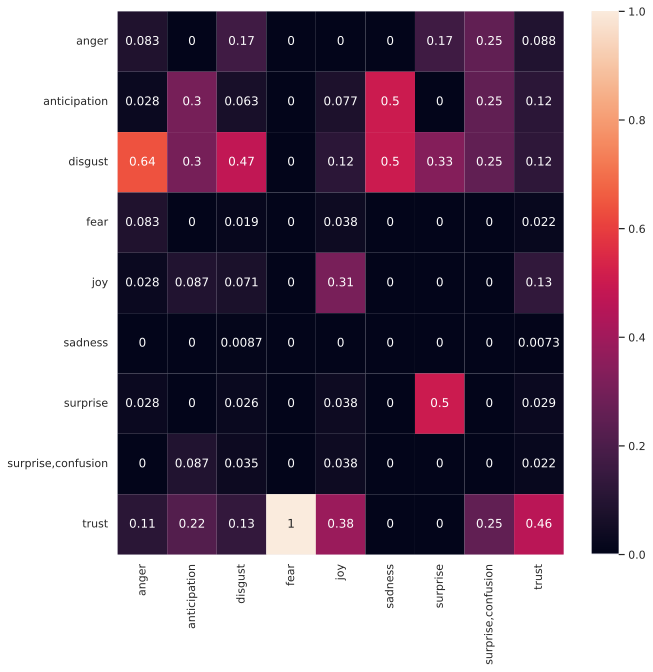

In [72]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_metrics["SVC(C=2, kernel='poly')"], annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

In [81]:
## Original metrics
confusion_metrics = {}
for model in models:
    train_x, train_y = get_converted_data(trainx.apply(lambda x: clean_hashtags(x)), trainy)
    test_x, test_y = get_converted_data(testx.apply(lambda x: clean_hashtags(x)), testy)
    model.fit(train_x, train_y) 
    
    outcome = model.predict(test_x)  # Make it test data
    print(f"Performance in model: {model}")
    print(metrics.classification_report(test_y, outcome, target_names=label_encoder.classes_, zero_division=True))
    confusion_metrics[str(model).replace("()", "")] = metrics.confusion_matrix(
        test_y, 
        outcome,
        normalize="pred"
    )

Performance in model: DecisionTreeClassifier(max_depth=25)
                    precision    recall  f1-score   support

             anger       0.15      0.18      0.17       114
      anticipation       0.24      0.33      0.28        64
           disgust       0.55      0.58      0.57       327
              fear       0.25      0.11      0.15        18
               joy       0.27      0.26      0.26        70
           sadness       0.00      0.00      0.00         6
          surprise       0.21      0.17      0.19        24
surprise,confusion       0.18      0.12      0.14        26
             trust       0.54      0.41      0.47       162

          accuracy                           0.40       811
         macro avg       0.27      0.24      0.25       811
      weighted avg       0.41      0.40      0.40       811

Performance in model: RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=250)
                    precision    recall  f1-score   support
